# ***THIS CODE HAS NOT BEEN COMPLETED RUNNING DUE TO TIME LIMITAIONS***

#Libraries Used

In [ ]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import dcg_score
from collections import Counter

#Google Drive Mount

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/test_and_train.csv'

df = pd.read_csv(file_path)

Mounted at /content/drive


<ipython-input-2-1de116531417>:6: DtypeWarning: Columns (50,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


#Converting 'date' column to datetime objects

In [ ]:
# Convert the 'date' column to datetime objects
df['meeting_date'] = pd.to_datetime(df['meeting_date'])

# Sort the DataFrame by the 'date' column in ascending order
df_sorted = df.sort_values(by='meeting_date')

# Print the sorted DataFrame (optional)
print(df_sorted)

       meeting_date  course_id  Unnamed: 0  race_number  horse_code  \
176050   2014-02-11         47           0            3      312037   
176047   2014-02-11         47           0            6      360458   
176046   2014-02-11          2           0            4      321870   
176045   2014-02-11          2           0            2      351605   
176044   2014-02-11          2           0            5      224734   
...             ...        ...         ...          ...         ...   
175923   2021-11-15         40           0            5      514475   
175922   2021-11-15         29           0            6      471914   
175921   2021-11-15         29           0            5      557760   
175929   2021-11-15         40           0            6      496189   
175983   2021-11-15         29           0            1      558279   

       course_name country_code            horse_name  horse_age horse_gender  \
176050   SOUTHWELL          GBR        ARABIAN FLIGHT          5  

In [ ]:
print(df.shape)

(922755, 250)


#Handling Missing Values

In [ ]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

equipment_char                             591901
horses_for_course_neg                         122
pre_race_master_symbol                     700788
jockey_uplift                                 122
trainer_uplift                                122
                                            ...  
hrs_best_last_10_mordin_speed_rank         112858
hrs_best_all_mordin_speed_rank             112858
hrs_best_all_mordin_speed_going            112858
hrs_best_last_3_mordin_speed_going         112858
hrs_best_last_3_mordin_speed_rank_going    112858
Length: 77, dtype: int64


In [ ]:
# Calculate the threshold for 30% missing values
threshold = len(df) * 0.3
# Drop columns where the number of missing values exceeds the threshold, excluding 'position_official'
columns_to_drop = df.columns[(df.isnull().sum() > threshold) & (df.columns != 'position_official')]
df = df.drop(columns=columns_to_drop)

# For numerical columns, use mean imputation
num_imputer = SimpleImputer(strategy='mean')
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# For categorical columns, use the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])
# Display the columns that were dropped and the new shape of the dataframe
print("Dropped Columns:", list(columns_to_drop))
print("New DataFrame Shape:", df.shape)

Dropped Columns: ['equipment_char', 'pre_race_master_symbol', 'form_figures', 'crs_dis_win_fav_text', 'hrs_best_fp_7to12', 'hrs_total_class_wins', 'hrs_days_since_incident']
New DataFrame Shape: (922755, 243)


#Filtering out races with less than 5 or more than 20 horses

In [ ]:
# Print the sorted DataFrame
print(df)

# Filter out races with less than 5 or more than 20 horses
df = df[(df['number_of_runners'] >= 5) & (df['number_of_runners'] <= 20)]

# Group by race id and count the number of winners
winners_per_race = df[df['win'] == 1].groupby('race_id').size()

# Identify races with more than one winner
races_with_multiple_winners = winners_per_race[winners_per_race > 1].index

# Filter out races with multiple winners
df = df[~df['race_id'].isin(races_with_multiple_winners)]

# Print the columns that were dropped and the new shape of the DataFrame
print("Dropped Columns: ['races with less than 5 or more than 20 horses', 'races with multiple winners']")
print("New DataFrame Shape:", df.shape)

       meeting_date  course_id  Unnamed: 0  race_number  horse_code  \
0        2020-08-01      211.0         0.0          6.0    475152.0   
1        2020-08-01       21.0         0.0          3.0    504268.0   
2        2020-08-01      211.0         0.0          1.0    504865.0   
3        2020-08-01      211.0         0.0          7.0    458970.0   
4        2020-08-01       20.0         0.0          5.0    513207.0   
...             ...        ...         ...          ...         ...   
922750   2020-07-31      214.0         0.0          3.0    528630.0   
922751   2020-07-31       41.0         0.0          8.0    496848.0   
922752   2020-07-31       41.0         0.0          4.0    507778.0   
922753   2020-07-31       41.0         0.0          4.0    476325.0   
922754   2020-07-31       30.0         0.0          9.0    505069.0   

           course_name country_code            horse_name  horse_age  \
0            KILBEGGAN          IRE       JOSEPHINA (IRE)        7.0   
1  

#Defining Pre-Race features and developing a correaltion matrix

In [ ]:
# Create a copy of the original dataframe
df_original = df.copy()

# Define the list of pre-race features to keep
pre_race_features = [
    'meeting_date', 'course_id', 'race_number', 'horse_code', 'course_name', 'country_code', 'horse_name', 'horse_age',
    'horse_gender', 'draw', 'weight_carried', 'jockey_name', 'jockey_code', 'apprentice_claim', 'trainer_name',
    'trainer_code', 'owner_name', 'owner_code', 'equipment', 'equipment_char', 'handicap_mark', 'long_handicap',
    'horses_for_course_neg', 'horses_for_course_pos', 'pre_race_adjusted_rating', 'pre_race_master_rating',
    'pre_race_epf', 'pre_race_master_symbol', 'horse_in_focus', 'warning_horse', 'jockey_uplift', 'trainer_uplift',
    'hot_trainer', 'cold_trainer', 'sectional_flag', 'top_rated', 'equipment_first_time', 'wind_op',
    'scheduled_time_gmt', 'scheduled_time_bst', 'actual_race_time_local', 'surface_type', 'race_type', 'distance_furlong',
    'race_title', 'going', 'going_abbrev', 'number_of_runners', 'number_of_places', 'race_code', 'prize_fund',
    'pre_race_review', 'race_class', 'bf_market_id', 'distance_type', 'race_id', 'saddle_cloth', 'significant_improver',
    'jockey_in_form', 'form_figures', 'entry_number', 'bha_rating', 'crs_dis_win_fav_text', 'days_off', 'bf_selection_id',
    'last_run_flat', 'last_run_jump', 'wins_at_course', 'wins_at_distance', 'wins_at_course_distance', 'penalty',
    'first_time_tongue_tie', 'trainer_off_break', 'trainer_first_time_equipment', 'trainer_handicap_debutants',
    'sire_cd', 'sire_going', 'novice', 'juvenile', 'hunter_chase', 'stakes', 'maiden', 'amateur', 'apprentice',
    'listed', 'handicap', 'race_type_v2', 'age_bin', 'long_hcap_bin', 'max_age_value', 'month', 'year', 'w_day',
    'week_no', 'win', 'distance_yards', 'dst_grps', 'hrs_career_races', 'hrs_lto_bsp_win_rank', 'hrs_days_off',
    'hrs_days_off_bin', 'hrs_last_2_form', 'hrs_first_run', 'hrs_lto_unfin', 'hrs_lto_unfin_fr', 'hrs_lto_unfin_fin',
    'hrs_lto_unfin_dnf', 'hrs_lto_race_type', 'hrs_race_type_delta', 'hrs_crs_win', 'hrs_dst_win', 'hrs_crs_dst_win',
    'hrs_crs_dst_nov_win', 'hrs_crs_dst_hcap_win', 'hrs_lto_in_the_money', 'hrs_lto_close_fp', 'hrs_lto_good_race',
    'hrs_consistency', 'hrs_consistency_bin', 'hrs_consistency_bin_100', 'hrs_consistency_bin_60',
    'hrs_consistency_bin_30', 'hrs_consistency_bin_10', 'hrs_consistency_bin_70', 'hrs_consistency_bin_80',
    'hrs_consistency_bin_90', 'hrs_days_since_good_race', 'hrs_has_going_wins', 'hrs_lto_winning_margin',
    'hrs_lto_winning_margin_lost', 'hrs_lto_winning_margin_close_fin', 'hrs_lto_winning_margin_good_fin',
    'hrs_prms_blank', 'hrs_prms_small_p', 'hrs_prms_plus', 'hrs_prms_question', 'hrs_prms_squiggle', 'hrs_prms_other',
    'hrs_lto_fp', 'hrs_lto_fp_imp', 'hrs_avg_life_fp', 'hrs_avg_life_fp_imp', 'hrs_wgt_fp', 'hrs_wgt_fp_imp',
    'hrs_ema_3_fp', 'hrs_ema_5_fp', 'hrs_hrs_ema_3_fp_imp', 'hrs_hrs_ema_5_fp_imp', 'hrs_best_all_time_lto_fp',
    'hrs_best_fp_10', 'hrs_best_fp_6', 'hrs_best_fp_3', 'hrs_best_fp_7to12', 'hrs_lto_win', 'hrs_lto_career_wins',
    'hrs_avg_life_wins', 'hrs_avg_life_wins_imp', 'hrs_wgt_win', 'hrs_wgt_win_imp', 'hrs_ema_3_win', 'hrs_ema_5_win',
    'hrs_ema_3_win_imp', 'hrs_ema_5_win_imp', 'hrs_sum_wins_last_10_races', 'hrs_won_in_last_10_races',
    'hrs_days_since_ran_x_lto_fp', 'hrs_lto_pcnt_beaten', 'hrs_lto_top_half_fin', 'hrs_lto_bottom_half_fin', 'hrs_lto_dbw',
    'hrs_avg_life_dbw', 'hrs_avg_life_dbw_imp', 'hrs_wgt_dbw', 'hrs_wgt_dbw_imp', 'hrs_ema_3_dbw', 'hrs_ema_5_wdbw',
    'hrs_ema_3_dbw_imp', 'hrs_ema_5_dbw_imp', 'hrs_lay_off', 'hrs_races_since_layoff', 'hrs_races_since_windop',
    'hrs_new_dist', 'hrs_lto_class', 'hrs_class_delta', 'hrs_race_code_delta', 'hrs_same_class_same_race_type',
    'hrs_down_class_same_race_type', 'hrs_up_class_same_race_type', 'hrs_up_class_diff_race_type',
    'hrs_down_class_diff_race_type', 'hrs_same_class_diff_race_type', 'hrs_class_wgt_fp', 'hrs_total_class_wins',
    'hrs_won_higher_class', 'hrs_total_wgt', 'hrs_lto_total_wgt', 'hrs_avg_life_total_wgt', 'hrs_wgt_total_wgt',
    'hrs_wgt_relative', 'hrs_wgt_relative_dst', 'hrs_first_time_equip', 'hrs_trn_delta', 'hrs_lto_incident',
    'hrs_days_since_incident', 'hrs_total_incidents', 'hrs_incident_rate', 'trn_par_bins', 'trn_par_hr', 'trn_par_prop',
    'trn_pareto_2', 'trn_pareto_20', 'trn_pareto_50', 'trn_pareto_10', 'trn_pareto_999', 'trn_pareto_5',
    'trn_pareto_100', 'jok_par_bins', 'jok_par_hr', 'jok_par_prop', 'jok_pareto_10', 'jok_pareto_5', 'jok_pareto_100',
    'jok_pareto_2', 'jok_pareto_50', 'jok_pareto_20', 'jok_pareto_999', 'trn_jok_par_bins', 'trn_jok_hr',
    'trn_jok_prop', 'trn_jok_pareto_100', 'trn_jok_pareto_999', 'trn_jok_pareto_2', 'position_official',
    'trn_jok_pareto_10', 'trn_jok_pareto_5', 'trn_jok_pareto_50', 'trn_hrs_cnt', 'trn_one_hrs', 'jok_career_races',
    'jok_debut', 'jok_races_in_day', 'jok_unique_races', 'jok_race_number', 'hrs_lto_mordin_speed',
    'hrs_lto_2_mordin_speed', 'hrs_lto_3_mordin_speed', 'hrs_best_last_3_mordin_speed', 'hrs_best_last_5_mordin_speed',
    'hrs_best_last_10_mordin_speed', 'hrs_best_all_mordin_speed', 'hrs_lto_mordin_speed_rank', 'hrs_lto_2_mordin_speed_rank',
    'hrs_lto_3_mordin_speed_rank', 'hrs_best_last_3_mordin_speed_rank', 'hrs_best_last_5_mordin_speed_rank',
    'hrs_best_last_10_mordin_speed_rank', 'hrs_best_all_mordin_speed_rank', 'hrs_best_all_mordin_speed_going',
    'hrs_best_last_3_mordin_speed_going', 'hrs_best_last_3_mordin_speed_rank_going,'
]

# Keep only the pre-race features that exist in the dataframe
df = df[[feature for feature in pre_race_features if feature in df.columns]]

# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numerical_df.corr()

# Define a threshold for high correlation (positive or negative)
corr_threshold = 0.6

# Identify columns with high absolute correlation (above threshold)
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            high_corr_features.add(correlation_matrix.columns[i])
            high_corr_features.add(correlation_matrix.columns[j])

# Keep only columns with high positive or negative correlation, ensuring 'meeting_date' and 'position_official' are kept
df = df[list(high_corr_features)]
for col in ['meeting_date', 'position_official']:
    if col in df_original.columns:
        df[col] = df_original[col]

# Display the columns that were kept and the new shape of the dataframe
print("Kept Columns with High Correlation:", list(df.columns))
print("New DataFrame Shape after Keeping Highly Correlated Columns:", df.shape)


Kept Columns with High Correlation: ['saddle_cloth', 'hrs_wgt_win', 'hrs_total_incidents', 'trn_jok_par_bins', 'hrs_down_class_diff_race_type', 'bha_rating', 'trn_par_prop', 'hrs_best_all_time_lto_fp', 'hrs_hrs_ema_3_fp_imp', 'pre_race_master_rating', 'hrs_first_run', 'hrs_ema_3_fp', 'hrs_wgt_fp', 'hrs_won_in_last_10_races', 'pre_race_adjusted_rating', 'hrs_best_last_3_mordin_speed', 'hrs_best_last_3_mordin_speed_going', 'hrs_best_last_3_mordin_speed_rank', 'hrs_lto_winning_margin_close_fin', 'trn_par_hr', 'hrs_incident_rate', 'hrs_wgt_total_wgt', 'jok_race_number', 'days_off', 'hrs_best_last_10_mordin_speed_rank', 'jok_par_prop', 'hrs_class_wgt_fp', 'hrs_wgt_relative_dst', 'hrs_lto_bsp_win_rank', 'hrs_race_type_delta', 'age_bin', 'hrs_wgt_dbw_imp', 'jok_pareto_999', 'hrs_wgt_fp_imp', 'hrs_lto_fp_imp', 'hrs_best_last_10_mordin_speed', 'hrs_wgt_dbw', 'trn_pareto_999', 'jok_pareto_100', 'hrs_ema_5_win_imp', 'hrs_avg_life_fp_imp', 'trn_par_bins', 'race_class', 'wins_at_distance', 'trn_jok

<ipython-input-8-b7447f5d575c>:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = df_original[col]
<ipython-input-8-b7447f5d575c>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df_original[col]


#Plotting Graph for the pairs of column with highly positive correlation or highly negetive correlation

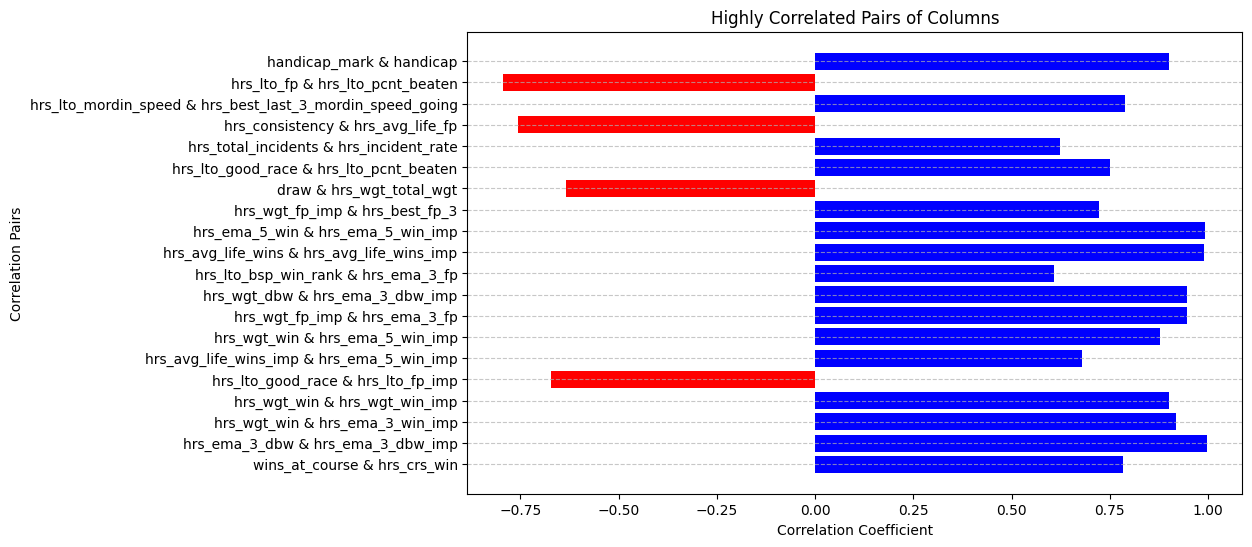

In [ ]:
# Plot pairs of columns with high correlation
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > corr_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

# Identify pairs with high correlation and select any 20 pairs for plotting
import random
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > corr_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

# Randomly select 20 pairs from the high correlation pairs
high_corr_pairs = random.sample(high_corr_pairs, min(20, len(high_corr_pairs)))

# Plot the most highly correlated pairs
plt.figure(figsize=(10, 6))
plt.barh([f"{pair[0]} & {pair[1]}" for pair in high_corr_pairs], [pair[2] for pair in high_corr_pairs], color=['blue' if pair[2] > 0 else 'red' for pair in high_corr_pairs])

plt.ylabel('Correlation Pairs')
plt.xlabel('Correlation Coefficient')
plt.title('Highly Correlated Pairs of Columns')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Display the new shape of the dataframe after removing poorly correlated features
print("New DataFrame Shape after Removing Poorly Co-related features:", df.shape)

New DataFrame Shape after Removing Poorly Co-related features: (882983, 124)


#Feature Normalization

In [ ]:
# Feature Normalization
scaler = StandardScaler()

# Identify numerical columns and exclude datetime columns
numerical_cols = df.select_dtypes(include=['number']).columns
datetime_cols = df.select_dtypes(include=['datetime']).columns

# Apply normalization to numerical features only
df_scaled = df.copy()  # Create a copy to preserve the original dataframe
df_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display the new shape of the dataframe after normalization
print("DataFrame Shape after Normalization:", df_scaled.shape)


DataFrame Shape after Normalization: (882983, 124)


#Sorting of the dataset on the basis of meeting date and rece number with Test, Train and Validation split

In [ ]:
# Ensure 'meeting_date' is in datetime format
df_original['meeting_date'] = pd.to_datetime(df_original['meeting_date'])

# Sort data by 'meeting_date' and 'race_number'
df_sorted = df_original.sort_values(by=['meeting_date', 'race_number'])

# Split the data based on date ranges
train_data = df_sorted[df_sorted['meeting_date'] < '2019-05-01']
val_data = df_sorted[(df_sorted['meeting_date'] >= '2019-05-01') & (df_sorted['meeting_date'] < '2020-05-01')]
test_data = df_sorted[(df_sorted['meeting_date'] >= '2020-05-01') & (df_sorted['meeting_date'] < '2021-05-01')]

# Drop datetime columns from train, validation, and test datasets
datetime_cols = df_sorted.select_dtypes(include=['datetime']).columns
train_data = train_data.drop(columns=datetime_cols, errors='ignore')
val_data = val_data.drop(columns=datetime_cols, errors='ignore')
test_data = test_data.drop(columns=datetime_cols, errors='ignore')

# Drop all non-numeric columns from train, validation, and test datasets
train_data = train_data.select_dtypes(include=['number'])
val_data = val_data.select_dtypes(include=['number'])
test_data = test_data.select_dtypes(include=['number'])

# Define features and target by dropping the target variable column
X_train = train_data.drop(columns=['win'], errors='ignore')
y_train = df_original.loc[train_data.index, 'win']
X_val = val_data.drop(columns=['win'], errors='ignore')
y_val = df_original.loc[val_data.index, 'win']
X_test = test_data.drop(columns=['win'], errors='ignore')
y_test = df_original.loc[test_data.index, 'win']
# Verify that all columns are numeric
print("X_train column types:\n", X_train.dtypes)

X_train column types:
 course_id                                  float64
Unnamed: 0                                 float64
race_number                                float64
horse_code                                 float64
horse_age                                  float64
                                            ...   
hrs_best_last_10_mordin_speed_rank         float64
hrs_best_all_mordin_speed_rank             float64
hrs_best_all_mordin_speed_going            float64
hrs_best_last_3_mordin_speed_going         float64
hrs_best_last_3_mordin_speed_rank_going    float64
Length: 219, dtype: object


#MLP model development with custom loss function

In [ ]:
# Define a custom loss function by inheriting nn.Module
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predictions, targets):
        # Apply cross-entropy loss
        loss = nn.CrossEntropyLoss()(predictions, targets)
        return loss

In [ ]:
# Define the neural network
class CustomMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(CustomMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], output_size)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# Initialize model, optimizer, and custom loss function
input_size = X_train.shape[1]
hidden_sizes = [50, 25, 10]
output_size = 2  # Binary classification
model = CustomMLP(input_size, hidden_sizes, output_size)

# Use the custom loss function
criterion = CustomLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
# Group data by race_id for training, validation, and testing
race_groups_train = {race_id: X_train.loc[X_train.index[df_original.loc[train_data.index, 'race_id'] == race_id]]
                     for race_id in df_original.loc[train_data.index, 'race_id'].unique()}
race_groups_val = {race_id: X_val.loc[X_val.index[df_original.loc[val_data.index, 'race_id'] == race_id]]
                   for race_id in df_original.loc[val_data.index, 'race_id'].unique()}
race_groups_test = {race_id: X_test.loc[X_test.index[df_original.loc[test_data.index, 'race_id'] == race_id]]
                    for race_id in df_original.loc[test_data.index, 'race_id'].unique()}

In [ ]:
# Training loop
num_epochs = 1
training_losses = []
validation_losses = []

# Training Loop
for race_id, race_data in race_groups_train.items():  # Ensure `.items()` is used
    race_X = torch.tensor(race_data.values, dtype=torch.float32)
    race_y = torch.tensor(
        y_train[df_original.loc[train_data.index, 'race_id'] == race_id].values,
        dtype=torch.long
    )

    # Forward pass
    outputs = model(race_X)
    loss = criterion(outputs, race_y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    epoch_loss += loss.item()

    training_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validate on race blocks
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for race_id, race_data in race_groups_val.items():  # Use `.items()`
           race_X = torch.tensor(race_data.values, dtype=torch.float32)
           race_y = torch.tensor(
           y_val[df_original.loc[val_data.index, 'race_id'] == race_id].values,
           dtype=torch.long
    )
    val_outputs = model(race_X)
    val_loss += criterion(val_outputs, race_y).item()


    validation_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_predictions = torch.max(test_outputs, 1)

# Calculate metrics
test_accuracy = accuracy_score(y_test_tensor, test_predictions)
print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test_tensor, test_predictions, target_names=['Did Not Win', 'Win']))


Epoch [1/1], Training Loss: 475113.8403
Epoch [1/1], Validation Loss: 47269.3555
Epoch [1/1], Training Loss: 535916.7153
Epoch [1/1], Validation Loss: 41679.6094
Epoch [1/1], Training Loss: 576869.3910
Epoch [1/1], Validation Loss: 36416.8711
Epoch [1/1], Training Loss: 605516.8344
Epoch [1/1], Validation Loss: 31538.7129
Epoch [1/1], Training Loss: 646990.7719
Epoch [1/1], Validation Loss: 26763.4824
Epoch [1/1], Training Loss: 688989.6274
Epoch [1/1], Validation Loss: 22101.2031
Epoch [1/1], Training Loss: 712811.7778
Epoch [1/1], Validation Loss: 17650.6504
Epoch [1/1], Training Loss: 732636.2602
Epoch [1/1], Validation Loss: 13441.3662
Epoch [1/1], Training Loss: 744437.8666
Epoch [1/1], Validation Loss: 9360.5869
Epoch [1/1], Training Loss: 754773.7211
Epoch [1/1], Validation Loss: 6106.1411
Epoch [1/1], Training Loss: 760132.9824
Epoch [1/1], Validation Loss: 2920.0315
Epoch [1/1], Training Loss: 765001.4203
Epoch [1/1], Validation Loss: 463.1331
Epoch [1/1], Training Loss: 76530